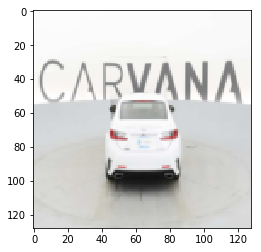

(128, 128, 3)


In [35]:
import os
import numpy as np
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Reshape, Dense, Conv2D, Input, MaxPool2D, UpSampling2D, Concatenate, Conv2DTranspose
from keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from keras.optimizers import Adam
from scipy.misc import imresize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import keras.backend.tensorflow_backend as KTF

train_dir = 'train/'
mask_dir = 'train_masks/'
all_images = os.listdir(train_dir)
# print(all_images)

# original_mask = load_img(mask_dir + images[i].split(".")[0] + '_mask.gif')

train_images, validation_images = train_test_split(all_images, train_size=0.01, test_size=0.01)

def img(images):

    while True:
        ix = np.random.choice(np.arange(len(images)), 5)
        imgs = []
        masks = []
        labels = []
        for i in ix:
            original_img = load_img(train_dir + images[i])
            array_original_img = img_to_array(original_img)/255
            shape = array_original_img.shape
            resized_img = imresize(array_original_img, [128, 128]+[3])
            imgs.append(resized_img)

            original_mask = load_img(mask_dir + images[i].split(".")[0] + '_mask.gif')
#         .convert('RGBA')
            array_mask_img = img_to_array(original_mask)/255
            resized_mask = imresize(array_mask_img, [128, 128]+[3])
            masks.append(resized_mask[:, :, 0])
        
        imgs = np.array(imgs)
        labels = np.array(masks)
        yield imgs, labels.reshape(-1, 128, 128, 1)
        

data_img = img(train_images)
train_img, mask_img = next(data_img)
plt.imshow(train_img[0])
# plt.imshow(mask_img[0], alpha=0.5)
plt.show()
print(train_img[0].shape)
    

In [39]:
model = Sequential()

model.add(Conv2D(64, (3, 3), input_shape=(128, 128, 3), padding='same'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))

model.add(UpSampling2D((2, 2)))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(1, (3, 3), padding='same', activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_75 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 64, 64, 128)       73856     
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 64, 64, 128)       147584    
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 32, 32, 256)       295168    
__________

In [23]:
# Now let's use Tensorflow to write our own dice_coeficcient metric
def dice_coef(y_true, y_pred):
    smooth = 1e-5
    
    y_true = tf.round(tf.reshape(y_true, [-1]))
    y_pred = tf.round(tf.reshape(y_pred, [-1]))
    
    isct = tf.reduce_sum(y_true * y_pred)
    
    return 2 * isct / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred))

Epoch 1/5
5/5 [==============================] - 7s - loss: -615.0417 - dice_coef: 1.7716     
Epoch 2/5
5/5 [==============================] - 6s - loss: -745.4576 - dice_coef: 1.9584     
Epoch 3/5
5/5 [==============================] - 5s - loss: -848.5582 - dice_coef: 1.9636     
Epoch 4/5
5/5 [==============================] - 6s - loss: -824.4447 - dice_coef: 1.9627     
Epoch 5/5
5/5 [==============================] - 5s - loss: -808.8617 - dice_coef: 1.9614     


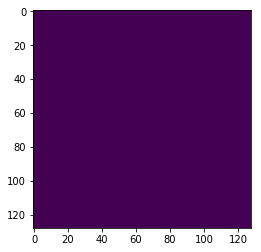

In [40]:
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=[dice_coef])
session = tf.Session('')
KTF.set_session(session)
KTF.set_learning_phase(1)
model.fit_generator(data_img, steps_per_epoch=5, epochs=5)

masks = model.predict(train_img)
plt.imshow(masks[0].reshape(128, 128), alpha=1)
#     plt.imshow(train_img[0], alpha=0.1)
plt.show()

In [ ]:
    image = model.predict(train_img)
    plt.imshow(image)
    # plt.imshow(mask_img[0], alpha=0.5)
    plt.show()